In [1]:
# a script to suggest sensitive species from the mechanism

In [73]:
import cantera as ct
import numpy as np
import signal
import os
import copy
import scipy.interpolate
import logging

import pandas as pd

import matplotlib.pyplot as plt
import simulation

In [25]:
ct.__version__

'3.2.0'

In [79]:
mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/cantera/chem_annotated.yaml'
gas = ct.Solution(mech_yaml)
surf = ct.Interface(mech_yaml, "surface1", [gas])

In [80]:
gas_out, surf_out, gas_rates, surf_rates = simulation.run_simulation(mech_yaml)

DEBUG:root:Loaded mechanism file: /home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/cantera/chem_annotated.yaml


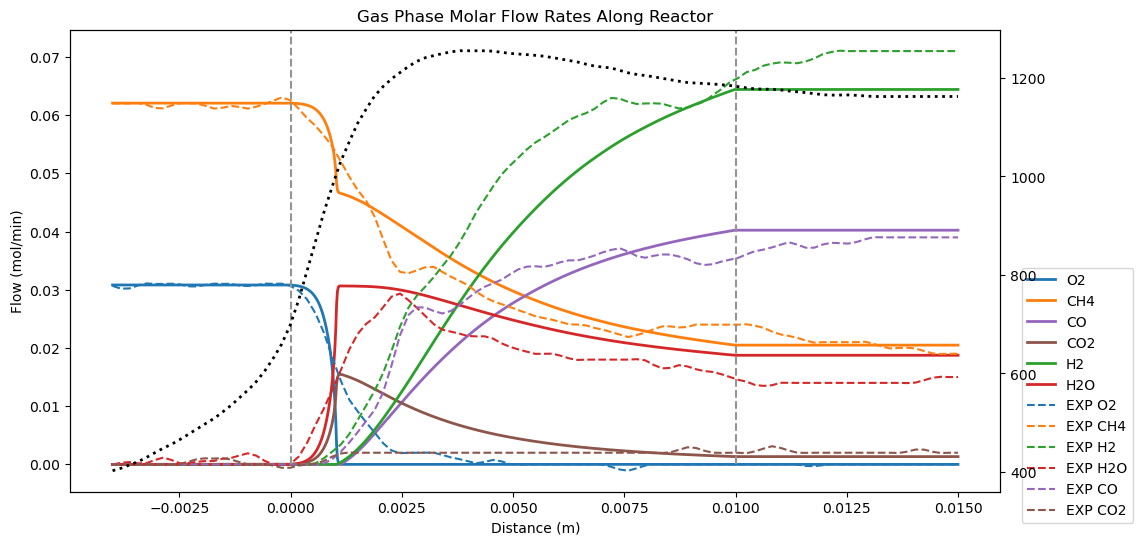

In [81]:
simulation.plot_gas_results(gas_out, gas)

In [82]:
# Get indices of key species

def get_i_thing(ref_composition, phase):
    """Helper function for getting the index of a species in a Cantera phase given its composition"""
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False, f"Could not find species with composition {ref_composition} in phase {phase.name}"

def increase_enthalpy(phase, species_index, increase_enthalpy_J_per_mol):
    """Helper function for increasing the enthalpy of a species in a Cantera phase by a specified amount (in J/mol)"""
    if ct.__version__ in ['3.2.0']:
        data_copy = phase.species()[species_index].input_data.copy()
    else:
        print('here')
        data_copy = copy.deepcopy(phase.species()[species_index].input_data)
    for i in range(len(data_copy['thermo']['data'])):
        data_copy['thermo']['data'][i][5] += increase_enthalpy_J_per_mol * 1000.0 / ct.gas_constant  # Cantera needs J / kmol
    new_sp = ct.Species().from_dict(data_copy)
    phase.modify_species(species_index, new_sp)

i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_X = get_i_thing({'X': 1.0}, surf)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_H2O = get_i_thing({'O': 1.0, 'H': 2.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)


In [83]:
def get_O2(gas, surf):
    N_REACTORS = 11
    MIN_SIM_DIST = -0.004  # in meters
    MAX_SIM_DIST = 0.015  # in meters
    TOTAL_PFR_LEN = MAX_SIM_DIST - MIN_SIM_DIST
    INDIVIDUAL_CSTR_LEN = TOTAL_PFR_LEN / N_REACTORS
    dist_array = np.linspace(MIN_SIM_DIST, MAX_SIM_DIST, N_REACTORS)
    
    
    REACTOR_DIAMETER = 0.0165
    CROSS_SECTION_AREA = (REACTOR_DIAMETER / 2.0) ** 2.0 * np.pi
    POROSITY = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
    CAT_AREA_PER_VOL = 16000  # made-up
    FLOW_RATE_SLPM = 4.7  # slpm
    FLOW_RATE = FLOW_RATE_SLPM * 0.001 / 60  # m^3/s
    velocity = FLOW_RATE / CROSS_SECTION_AREA  # m/s
    residence_time = INDIVIDUAL_CSTR_LEN / velocity # unit in s
    individual_cstr_vol = CROSS_SECTION_AREA * INDIVIDUAL_CSTR_LEN * POROSITY
    individual_cstr_cat_area = CAT_AREA_PER_VOL * individual_cstr_vol
    T_INLET = 700.0  # K  -- won't matter if using the temperature profile
    P_INLET = ct.one_atm  # Pa
    x_CH4 = 0.296  # inlet mole fraction of methane
    x_O2 = 0.147
    x_Ar = 1.0 - x_CH4 - x_O2
    
    X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'
    gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
    mass_flow_rate = FLOW_RATE * gas.density_mass
    gas.TPX = T_INLET, P_INLET, X
    surf.TP = T_INLET, P_INLET
    
    initial_coverages = np.zeros_like(surf.coverages)
    initial_coverages[i_X] = 1.0
    surf.coverages = initial_coverages
    
    
    # create a new reactor
    r = ct.IdealGasReactor(gas, energy='off')
    r.volume = individual_cstr_vol
    upstream = ct.Reservoir(gas, name='upstream')
    downstream = ct.Reservoir(gas, name='downstream')
    rsurf = ct.ReactorSurface(surf, r, A=individual_cstr_cat_area)
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
    if ct.__version__ in ['2.6.0']:
        v = ct.PressureController(r, downstream, master=m, K=1e-5)
    else:
        v = ct.PressureController(r, downstream, primary=m, K=1e-5)
    
    sim = ct.ReactorNet([r])
    
    
    
    sim.initial_time = 0.0
    # sim.advance(sim.time + 1e4 * residence_time)
    sim.advance_to_steady_state()
    return r.phase.X[i_O2]

In [84]:
gas = ct.Solution(mech_yaml)
surf = ct.Interface(mech_yaml, "surface1", [gas])
baseline = get_O2(gas, surf)

/tmp/ipykernel_231933/321988960.py:38: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasReactor(gas, energy='off')
/tmp/ipykernel_231933/321988960.py:40: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  upstream = ct.Reservoir(gas, name='upstream')
/tmp/ipykernel_231933/321988960.py:41: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reac

In [85]:
sens_concs = np.zeros(surf.n_species)
increase_enthalpy_J_per_mol = 410
for i in range(1, surf.n_species):
    gas = ct.Solution(mech_yaml)
    surf = ct.Interface(mech_yaml, "surface1", [gas])

    increase_enthalpy(surf, i, increase_enthalpy_J_per_mol)
    sens_concs[i] = get_O2(gas, surf)
sens_rates = np.zeros(surf.n_reactions)
for i in range(1, surf.n_reactions):
    gas = ct.Solution(mech_yaml)
    surf = ct.Interface(mech_yaml, "surface1", [gas])

    surf.set_multiplier(1.1, i)
    sens_rates[i] = get_O2(gas, surf)

/tmp/ipykernel_231933/321988960.py:38: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasReactor(gas, energy='off')
/tmp/ipykernel_231933/321988960.py:40: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  upstream = ct.Reservoir(gas, name='upstream')
/tmp/ipykernel_231933/321988960.py:41: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reac

In [86]:
# plot the top contenders
spec_sensitivities = (sens_concs - baseline) / baseline
indices = np.arange(surf.n_species)
sorted_order = [x for _, x in sorted(zip(np.abs(spec_sensitivities), indices))][::-1]

for i in range(10):
    j = sorted_order[i]
    print(f'{j}\t{surf.species_names[j]}\t{spec_sensitivities[j]:0.7f}')

0	X(1)	-1.0000000
10	OHX(30)	0.0010855
4	OX(24)	-0.0005928
11	H2OX(31)	-0.0005831
5	CH2X(25)	0.0000095
15	CH2OX(119)	0.0000003
7	CHX(27)	-0.0000003
6	CH3X(26)	0.0000002
1	HX(21)	0.0000001
13	O[C]#[Pt](88)	0.0000000


In [89]:
# plot the top contenders
rxn_sensitivities = (sens_rates - baseline) / baseline
indices = np.arange(surf.n_reactions)
sorted_order = [x for _, x in sorted(zip(np.abs(rxn_sensitivities), indices))][::-1]

for i in range(100):
    j = sorted_order[i]
    print(f'{j}\t{surf.reactions()[j].equation}\t{rxn_sensitivities[j]:0.7f}')

0	O2(3) + 2 X(1) <=> 2 OX(24)	-1.0000000
11	CH4(2) + OX(24) + X(1) <=> CH3X(26) + OHX(30)	-0.0065220
14	CH4(2) + OHX(30) + X(1) <=> CH3X(26) + H2OX(31)	-0.0016767
17	H2OX(31) + OX(24) <=> 2 OHX(30)	0.0007354
28	CH3OH(14) + 2 X(1) <=> CH3X(26) + OHX(30)	0.0000130
34	CH2X(25) + OHX(30) <=> CH3X(26) + OX(24)	-0.0000120
16	H2OX(31) + X(1) <=> HX(21) + OHX(30)	0.0000010
13	OHX(30) + X(1) <=> HX(21) + OX(24)	-0.0000008
9	CHX(27) + X(1) <=> CX(28) + HX(21)	0.0000004
63	CH2OX(119) + X(1) <=> CHX(27) + OHX(30)	-0.0000004
6	CH3X(26) + HX(21) <=> CH4(2) + 2 X(1)	-0.0000004
5	CH2X(25) + HX(21) <=> CH3X(26) + X(1)	0.0000002
21	OH(17) + X(1) <=> OHX(30)	-0.0000000
27	CH2O(9) + 2 X(1) <=> CH2X(25) + OX(24)	0.0000000
33	CHX(27) + OHX(30) <=> CH2X(25) + OX(24)	-0.0000000
19	CH3(10) + X(1) <=> CH3X(26)	-0.0000000
68	CH2OX(119) + X(1) <=> HX(21) + O[C]#[Pt](88)	0.0000000
74	OHX(30) + O[C]#[Pt](88) <=> CH2OX(119) + OX(24)	-0.0000000
8	COX(23) + X(1) <=> CX(28) + OX(24)	0.0000000
2	H2(6) + 2 X(1) <=> 2 HX(

In [60]:
differences

array([1.00000000e+00, 4.38272328e-03, 1.19949159e-05, 1.73279931e-02,
       1.31310909e-03, 5.05503828e-04, 1.26970128e-03, 2.14040611e-07,
       1.69111948e-02, 2.50319880e-07, 5.75206019e-03, 1.67820554e-02,
       8.02641872e-05, 2.35337222e-06, 1.07469130e-06, 4.59668058e-12,
       9.60323582e-06, 1.27296529e-05, 6.46956897e-09, 3.46686333e-11,
       6.40306387e-12, 6.08062952e-12, 4.50315869e-12, 3.08758769e-12])

In [57]:
sens_concs

array([0.        , 0.00094877, 0.00095294, 0.00093643, 0.0009517 ,
       0.00095247, 0.00095174, 0.00095295, 0.00093683, 0.00095295,
       0.00094747, 0.00093695, 0.00095287, 0.00095294, 0.00095295,
       0.00095295, 0.00095294, 0.00095296, 0.00095295, 0.00095295,
       0.00095295, 0.00095295, 0.00095295, 0.00095295])

In [29]:
surf.species()[1].input_data

{'name': 'HX(21)',
 'composition': {'H': 1.0, 'X': 1.0},
 'thermo': {'model': 'NASA7',
  'temperature-ranges': [298.0, 1000.0, 2000.0],
  'data': [[-2.07570125,
    0.0173580835,
    -2.60920784e-05,
    1.89282268e-08,
    -5.38835643e-12,
    -3166.18959,
    8.15361518],
   [2.72248139,
    -0.00106817206,
    1.9865379e-06,
    -1.12048461e-09,
    2.09811636e-13,
    -4218.23896,
    -15.320747]],
  'note': 'Thermo library: surfaceThermoPt111'}}

In [32]:
surf.species()[1].input_data.copy()

{'name': 'HX(21)',
 'composition': {'H': 1.0, 'X': 1.0},
 'thermo': {'model': 'NASA7',
  'temperature-ranges': [298.0, 1000.0, 2000.0],
  'data': [[-2.07570125,
    0.0173580835,
    -2.60920784e-05,
    1.89282268e-08,
    -5.38835643e-12,
    -3166.18959,
    8.15361518],
   [2.72248139,
    -0.00106817206,
    1.9865379e-06,
    -1.12048461e-09,
    2.09811636e-13,
    -4218.23896,
    -15.320747]],
  'note': 'Thermo library: surfaceThermoPt111'}}

/tmp/ipykernel_231933/1089119532.py:38: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasReactor(gas, energy='off')
/tmp/ipykernel_231933/1089119532.py:40: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  upstream = ct.Reservoir(gas, name='upstream')
/tmp/ipykernel_231933/1089119532.py:41: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this r

np.float64(0.04186747466242312)

In [14]:
r.phase.X

array([5.43477666e-01, 0.00000000e+00, 0.00000000e+00, 2.25664752e-01,
       4.18674747e-02, 6.29200961e-02, 7.70586061e-02, 4.87824415e-02,
       3.33216324e-07, 1.72747964e-07, 1.61626111e-08, 1.17864966e-12,
       3.88641309e-24, 1.04575116e-13, 3.88535596e-16, 2.28441411e-04,
       4.35843867e-18, 7.68377361e-16, 4.03356928e-12, 7.18108887e-17,
       1.85310420e-23, 1.24784872e-11, 2.78317454e-32, 2.11669367e-18,
       1.94209733e-22, 5.55533991e-35])

In [18]:
 # accept mechanism file or the gas and surf objects directly
    if not gas is None and not surf is None:
        assert isinstance(gas, ct.Solution), "gas must be a Cantera Solution object"
        assert isinstance(surf, ct.Interface), "surf must be a Cantera Interface object"
        logging.debug("Using provided gas and surface objects for simulation")
    elif mech_yaml is not None:
        gas = ct.Solution(mech_yaml)
        surf = ct.Interface(mech_yaml, "surface1", [gas])
        logging.debug(f"Loaded mechanism file: {mech_yaml}")
    else:
        raise ValueError("Either gas and surf objects or a mechanism file must be provided")
    

    # Apply perturbations to the surface thermodynamics
    if surf_thermo_perturb:
        for index in surf_thermo_perturb.keys():
            increase_enthalpy(surf, index, surf_thermo_perturb[index])
            logging.debug(f"Increased enthalpy of surface species {surf.species_names[index]} by {surf_thermo_perturb[index]} J/mol")
    
    # Get indices of key species
    i_Ar = get_i_thing({'Ar': 1.0}, gas)
    i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
    i_O2 = get_i_thing({'O': 2.0}, gas)
    i_X = get_i_thing({'X': 1.0}, surf)
    
    # Initialize the reactor
    X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'
    gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
    mass_flow_rate = FLOW_RATE * gas.density_mass
    gas.TPX = T_INLET, P_INLET, X
    surf.TP = T_INLET, P_INLET

    initial_coverages = np.zeros_like(surf.coverages)
    initial_coverages[i_X] = 1.0
    surf.coverages = initial_coverages

    
    # create a new reactor
    if use_temperature_profile:
        r = ct.IdealGasReactor(gas, energy='off')
    else:
        r = ct.IdealGasReactor(gas, energy='on')
    r.volume = individual_cstr_vol
    upstream = ct.Reservoir(gas, name='upstream')
    downstream = ct.Reservoir(gas, name='downstream')
    rsurf = ct.ReactorSurface(surf, r, A=individual_cstr_cat_area)
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
    if ct.__version__ in ['2.6.0']:
        v = ct.PressureController(r, downstream, master=m, K=1e-5)
    else:
        v = ct.PressureController(r, downstream, primary=m, K=1e-5)

    if wall_on and not use_temperature_profile:
        air = ct.Solution("air.yaml")
        air.TP = env_temp, ct.one_atm
        env = ct.Reservoir(air)

        # add a wall to the reactor
        w = ct.Wall(r, env, A=wall_area, U=U_hx)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # we already know the shape of the output arrays, so we should preallocate them for speed
    gas_out = np.zeros((N_REACTORS, gas.n_species)) + np.nan
    # Don't need to store these other outputs, but we could
    surf_out = np.zeros((N_REACTORS, surf.n_species)) + np.nan
    gas_rates = np.zeros((N_REACTORS, gas.n_reactions)) + np.nan
    surf_rates = np.zeros((N_REACTORS, surf.n_reactions)) + np.nan
    # T_array = np.zeros(N_REACTORS) + np.nan

    
    for n in range(N_REACTORS):

        # Set the state of the reservoir to match that of the previous reactor
        if use_temperature_profile:
            gas.TDY = temperature_profile[n], r.thermo.DP[0], r.thermo.Y
            # surf.TD = temperature_profile[n], surf.TD[1]
            r.syncState()
            upstream.syncState()
        else:
            gas.TDY = r.thermo.TDY
            upstream.syncState()
        
        sim.reinitialize()
        if n == CAT_ON_INDEX:
            # turn the surface reactions on as we enter the catalyst region
            surf.set_multiplier(1.0)

            # apply kinetic perturbations to the surface reactions
            if surf_kinetics_perturb:
                for index in surf_kinetics_perturb.keys():
                    surf.set_multiplier(surf_kinetics_perturb[index], index)
                    logging.debug(f"Set multiplier of surface reaction {surf.reactions()[index].equation} to {surf_kinetics_perturb[index]}")

        elif n == CAT_OFF_INDEX:
            # turn the surface reactions off as we exit the catalyst region
            surf.set_multiplier(0.0)

        try:
            sim.initial_time = 0.0
            sim.advance(sim.time + 1e4 * residence_time)
            # add timeout handling here if the simulation takes too long
        except (ct.CanteraError, ct._utils.CanteraError, TimeoutException) as e:
            signal.alarm(0)
        #except (ct.CanteraError, ct._utils.CanteraError) as e:
            logging.error(f"Cantera error at reactor {n}: {e}")
            return gas_out, surf_out, gas_rates, surf_rates

        
        kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
        gas_out[n, :] = 1000 * 60 * kmole_flow_rate * gas.X.copy()  # molar flow rate in moles/minute
        surf_out[n, :] = surf.X.copy()
        gas_rates[n, :] = gas.net_rates_of_progress
        surf_rates[n, :] = surf.net_rates_of_progress
        # T_array[n] = surf.T
        
        # Reset the alarm
        signal.alarm(0)

    return gas_out, surf_out, gas_rates, surf_rates

IndentationError: unexpected indent (1467989388.py, line 2)